In [1]:
import xarray as xr
import pandas as pd
import seaborn as sns

%matplotlib inline
import numpy as np
import pandas as pd
import xarray as xr
from matplotlib import pyplot as plt

In [2]:
# Make data extracts smaller for online consumption
pd.set_option("display.max_rows", 10)

In [13]:
columns = ['file', 'id', 'mics_no2', 'mics_co', 'alpha_no2_aux', 'alpha_no2_working', 'alpha_co_aux', 'alpha_co_working']
gascal_df = pd.read_csv('gascal.csv', header=None)
gascal_df.columns = columns
gascal_df.drop('file', axis=1, inplace=True)


# load calibration sheet from jukka
cal = pd.read_csv('vehicle_mount_analysis/V0_3_calibration.csv', index_col='ID')
cal = cal.T

# Convert to ppb

In [4]:
# conversion functions

# need calibration to determine r0
def convert_co_mics(v_out, r_0=150e3, r_1=1e6, vs=5.0*1000):
    # read some values off the graph for CO
    x = np.array([2., 10., 100.])
    y = np.array([2., 0.4, 0.06])
    m, c= np.polyfit(np.log10(y), np.log10(x), 1)
    
    # convert voltage to resistance    
    rs = r_1 / ((vs/v_out) - 1.0)
    # + 3 is to convert from ppm to ppb
    return 10.**(c + 3) * (rs / r_0)**m

def convert_no2_mics(v_out, r_0=3e3, r_1=56e3, vs=5.0*1000):
    # read some values off the graph for NO2
    x = np.array([0.3, 0.6, 3.])
    y = np.array([2., 4., 11.])
    m, c = np.polyfit(np.log10(y), np.log10(x), 1)
    
    rs = r_1 / ((vs/v_out) - 1.0)
    # + 3 is to convert from ppm to ppb
    return 10.**(c + 3) * (rs / r_0)**m

def convert_co_ID(ID, CO_working_mv, CO_aux_mv, temp_correction = +1):
    # temp corretion is +1 up to 20 deg Cels, then -1, then -0.7 after 30C
    CO_WORKING_ELECTRODE_ELECTRONIC_ZERO_MV  = cal[ID].CO_WE_ELECTRONIC_ZERO
    CO_AUXILIARY_ELECTRODE_ELECTRONIC_ZERO_MV  = cal[ID].CO_AUX_ELECTRONIC_ZERO
    #CO_SENSITIVITY = cal.loc[cal['ID'] == ID].CO_SENSITIVITY_mV_ppb; # mv/ppb
    CO_SENSITIVITY = cal[ID].CO_SENSITIVITY_nA_ppb; # nA/ppb
    CO_GAIN = cal[ID].CO_PCB_GAIN;

    scaled_working = (CO_working_mv - CO_WORKING_ELECTRODE_ELECTRONIC_ZERO_MV)/CO_GAIN
    
    scaled_aux =  (CO_aux_mv - CO_AUXILIARY_ELECTRODE_ELECTRONIC_ZERO_MV) / CO_GAIN*temp_correction
    
    return  (scaled_working - scaled_aux)/CO_SENSITIVITY

def convert_no2_ID(ID, NO2_working_mv, NO2_aux_mv, temp_correction = +1.09):
    # For A4 sensors: temp corretion is +1.09 up to 20 deg Cels, then 1.35, then 3 after 30C
    
    NO2_WORKING_ELECTRODE_ELECTRONIC_ZERO_MV  = cal[ID].NO2_WE_ELECTRONIC_ZERO;
    NO2_AUXILIARY_ELECTRODE_ELECTRONIC_ZERO_MV  = cal[ID].NO2_AUX_ELECTRONIC_ZERO;
    #NO2_SENSITIVITY = cal.loc[cal['ID'] == ID].NO2_SENSITIVITY_mV_ppb; # mv/ppb
    NO2_SENSITIVITY = cal[ID].NO2_SENSITIVITY_nA_ppb; # nA/ppb
    NO2_GAIN = cal[ID].NO2_PCB_GAIN;
    
    scaled_working = (NO2_working_mv - NO2_WORKING_ELECTRODE_ELECTRONIC_ZERO_MV)/NO2_GAIN
    
    scaled_aux =  (NO2_aux_mv - NO2_AUXILIARY_ELECTRODE_ELECTRONIC_ZERO_MV) / NO2_GAIN*temp_correction
        
    return  (scaled_working - scaled_aux)/NO2_SENSITIVITY

In [40]:
gascal_df['co_ppb_mics'] = convert_co_mics(gascal_df.mics_co)
gascal_df['no2_ppb_mics'] = convert_no2_mics(gascal_df.mics_no2)
gascal_df['co_ppb_alphasense'] = gascal_df[['id', 'alpha_co_working', 'alpha_co_aux']].apply(lambda x: convert_co_ID(x.values[0], x.values[1], x.values[2]), axis=1)
gascal_df['no2_ppb_alphasense'] = gascal_df[['id', 'alpha_no2_working', 'alpha_no2_aux']].apply(lambda x: convert_no2_ID(x.values[0], x.values[1], x.values[2]), axis=1)

# CO

## Mics

In [32]:
# convenience functions for easy grouping and plotting
def group_by_column_into_df(df, group_col, id_col='id'):
    gas_df = pd.DataFrame()
    for sensor_id in df[id_col].unique():
        temp = df[df[id_col] == sensor_id]
        temp.index = range(len(temp))
        gas_df[sensor_id] = temp[group_col]
    return gas_df
    
def plot_different_sensors(df, column, id_col='id'):
    gas_df = group_by_column_into_df(df, column, id_col)
    
    # convert to time in seconds
    gas_df.index = gas_df.index * 10 * 60 / len(gas_df.index)
    gas_df.plot()
    
    palette = sns.color_palette()
    for i in range(10):
        x = i*60
        plt.axvline(x, color=palette[0], alpha=0.3)

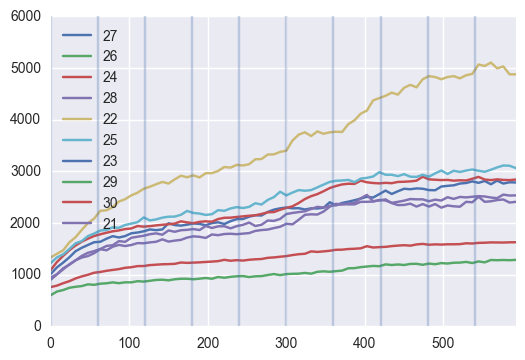

In [28]:
plot_different_sensors(gascal_df, 'co_ppb_mics')

Here blue lines are at one minute intervals. 

In [43]:
mics_co_df = group_by_column_into_df(gascal_df, 'co_ppb_mics')
mics_co_df.corr()

,27,26,24,28,22,25,23,29,30,21
27,1.000000,0.988332,0.978704,0.968355,0.988679,0.989851,NaN,NaN,0.992706,0.985086
26,0.988332,1.000000,0.977746,0.965696,0.993317,0.980367,NaN,NaN,0.982743,0.967716
24,0.978704,0.977746,1.000000,0.993240,0.974907,0.990158,NaN,NaN,0.989635,0.985616
28,0.968355,0.965696,0.993240,1.000000,0.961641,0.987299,NaN,NaN,0.983788,0.983689
22,0.988679,0.993317,0.974907,0.961641,1.000000,0.979991,NaN,NaN,0.984842,0.969416
25,0.989851,0.980367,0.990158,0.987299,0.979991,1.000000,NaN,NaN,0.994875,0.992505
23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
30,0.992706,0.982743,0.989635,0.983788,0.984842,0.994875,NaN,NaN,1.000000,0.995336
21,0.985086,0.967716,0.985616,0.983689,0.969416,0.992505,NaN,NaN,0.995336,1.000000


## Alphasense

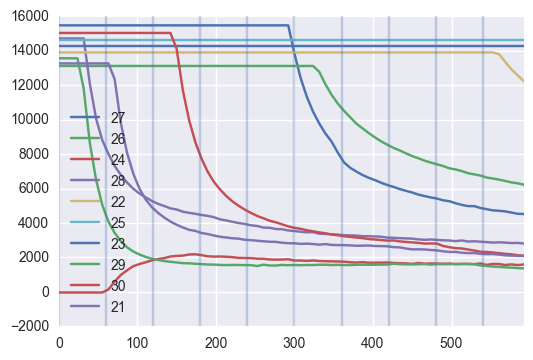

In [37]:
plot_different_sensors(gascal_df, 'co_ppb_alphasense')

# NO2

## Mics

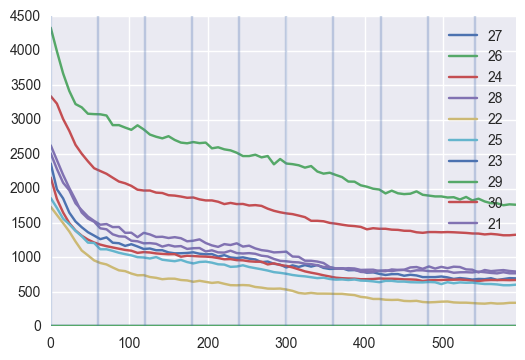

In [38]:
plot_different_sensors(gascal_df, 'no2_ppb_mics')

In [44]:
mics_no2_df = group_by_column_into_df(gascal_df, 'no2_ppb_mics')
mics_no2_df.corr()

,27,26,24,28,22,25,23,29,30,21
27,1.000000,0.975620,0.991648,0.986555,0.992178,0.991306,NaN,NaN,0.990479,0.991149
26,0.975620,1.000000,0.978505,0.976375,0.968352,0.977376,NaN,NaN,0.979088,0.954010
24,0.991648,0.978505,1.000000,0.994333,0.983796,0.991425,NaN,NaN,0.989169,0.985491
28,0.986555,0.976375,0.994333,1.000000,0.987314,0.994705,NaN,NaN,0.993642,0.987122
22,0.992178,0.968352,0.983796,0.987314,1.000000,0.993919,NaN,NaN,0.996541,0.994995
25,0.991306,0.977376,0.991425,0.994705,0.993919,1.000000,NaN,NaN,0.997451,0.991268
23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
30,0.990479,0.979088,0.989169,0.993642,0.996541,0.997451,NaN,NaN,1.000000,0.991163
21,0.991149,0.954010,0.985491,0.987122,0.994995,0.991268,NaN,NaN,0.991163,1.000000


## Alphasense

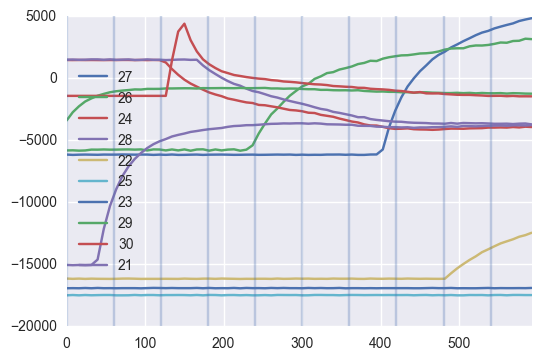

In [39]:
plot_different_sensors(gascal_df, 'no2_ppb_alphasense')